### Import library

Example 2 is inbalanced data set; ~2200 in PD and ~1100 in SNP
    Goal is to predict if mutation is SNP or PD
    XG Boost
        
    Total samples: 3368
    2254 PD samples
    1111 SNP samples
    3 NA samples

CV branch (best performance)

In [1]:
""" Imports the required libraries and packages """

import pandas as pd                                                              # Data manipulation in dataframes
import numpy as np                                                               # Array manipulation
import xgboost as xgb                                                            # Gradient boosting package

import random as rd                                                              # Random seed generation
import time                                                                      # Time program run time
import sys

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from xgboost import plot_importance

from sklearn.metrics import(
    matthews_corrcoef,                                                           # MCC for evaluation
    # balanced_accuracy_score, #hyperparameter evaluation
    # f1_score,  #hyperparameter evaluation
    confusion_matrix,                                                            # Confusion matrix for classification evalutation
    classification_report                                                        # Return the F1, precision, and recall of a prediction
    )

from sklearn.model_selection import(
    train_test_split,                                                            # Splits data frame into the training set and testing set
    # GridSearchCV,  # Searches all hyperparameters
    # RandomizedSearchCV, # Searches random range of hyperparameters
    GroupKFold                                                                   # K-fold CV with as groups
        )

from sklearn.utils import shuffle
# from sklearn.ensemble import RandomForestClassifier                              # SK learn API for classificastion random forests

np.set_printoptions(precision = 3,threshold=np.inf, suppress=True)               # Full array printing

### Split dataset into training and validation sets

In [2]:
def Train_Test_Split(file):
    """      
    Input:      file             Pre-processed dataset done by PDB2AC script

    Returns:    Training_Set     80% training set split
                Testing_Set      20% testing set split
                
    80% training and 20% testing split. Splits are shuffled randomly and index reset
    """
    AC_dataset                  = pd.read_csv(file, index_col=0)  
    Training_Set                = AC_dataset
        
    Training_Set, Testing_Set   = train_test_split(AC_dataset,train_size = 0.8)
        
    Training_Set.reset_index(drop=True, inplace = True) #Drop index to avoid training on index values
    Testing_Set.reset_index(drop=True, inplace = True)  #Reset index after splitting for compatability with group fold CV
    
    Training_Set                = Training_Set.sample(frac = 1) #Shuffle data after splitting
    Testing_Set                 = Testing_Set.sample(frac = 1)
    
    
    return Training_Set, Testing_Set

In [3]:
def test_matrix(Testing_Set):
    """      
    Input:      Testing_Set      20% testing set split

    Returns:    d_test           Testing data in dmatrix 
                TestData         Testing features 
                TestLabels       Testing labels
            
    Obtains the testing set's features and labels, and converts the testing set dataframe to a dmatrix for compatasbility with XG Boost API.
    """
    TestData     = Testing_Set.drop(['AC Code','dataset'], axis =1)         #Features for testing
    TestLabels   = Testing_Set['dataset']                                   #Class labels for testing
    
    d_test = xgb.DMatrix(TestData, TestLabels)

    return (d_test, TestData, TestLabels)

In [4]:
# def no_cv_data(Training_Set, Testing_Set):
#     """      
#     Input:      Training_Set     80% training set split
#                 Testing_Set      20% testing set split

#     Returns:    train_features   Features for training
#                 train labels     Class lables for training
#                 test_features    Features for testing
#                 test_labels      Class labels for testing
                
#     When not using CV, creates the datasets needed for GBM model training and predictions.
#     """
    
#     train_features     = Training_Set.drop(['AC Code','dataset'], axis =1)      
#     train_labels       = Training_Set['dataset']                                  
        
#     test_features     = Testing_Set.drop(['AC Code','dataset'], axis =1)         
#     test_labels       = Testing_Set['dataset']                                  
        
#     return(train_features, train_labels, test_features, test_labels

### Initial evaluation

In [5]:
# def test(inData, classData, ValData, Vallabel):
#     """ 
#     Input:      inData          Features for training
#                 classData       Class lables for training
#                 valData         Features for testing
#                 Vallabel        Class labels for testing

#     Evaluate training data before CV and balancing. Gradient boosting for prediction on the test data. 
#     True values are testing data class labels
#     """    
#     d_train = xgb.DMatrix(inData, classData)
#     d_test = xgb.DMatrix(ValData, Vallabel)

#     params = {
#     'booster': 'gbtree',
#     'objective': 'binary:hinge', 
#     }
#     XGB_initial = xgb.train(params, d_train)
    
#     Output_pred = XGB_initial.predict(d_test)
#     print(f"              **Initial Evaluation**")
#     print(f"Confusion Matrix:\n {confusion_matrix(Vallabel, Output_pred)}")
#     print(f"MCC              {matthews_corrcoef(Vallabel, Output_pred)}\n")


## Group K-fold CV (outer loop)

In [6]:
def CV(Training_Set):
    """      
    Input:      Training_Set     80% training set split
            
    Returns:    IT_list         List of training features for each fold
                LT_list         List of training class labels for each fold
                IV_list         List of validation features for each fold
                LV_list         List of validation class labels for each fold

    K-fold CV with protein groups separated between training and validation sets for each fold. Creates 5 folds.
    """
    
    features     = Training_Set.drop(['dataset'], axis =1)         #Features for training
    labels       = Training_Set['dataset']                         #Class labels for training
    groups       = Training_Set['AC Code'].to_list()               #List of proteins for grouping
    
    IT_list = []
    LT_list = []
    IV_list = []
    LV_list = []
    
    CV             = GroupKFold(n_splits = 5)                           #Creates 5 splits

    for train_idx, val_idx in CV.split(features, labels, groups):       #Generates the indices to be used for a training and validation split. Indicies are unique to train/ val sets

        Rd = np.random.randint(time.time())                                  #Random number from 1 to time since epoch

        Input_train                        = features.loc[train_idx]   #New dataframe from selected indices
        Classes_train                      = labels.loc[train_idx]
        Input_train.drop(['AC Code'], axis = 1, inplace = True)              #Group identifer not needed for training

                
        Input_val                          = features.loc[val_idx]
        Classes_val                        = labels.loc[val_idx]
        Input_val.drop(['AC Code'], axis   = 1, inplace = True)
        
        Input_train.reset_index(drop = True, inplace = True)
        Classes_train.reset_index(drop = True, inplace = True)
        Input_val.reset_index(drop = True, inplace = True)
        Classes_val.reset_index(drop = True, inplace = True)

        IT_list.append(Input_train.sample(frac=1, random_state=Rd))          #Shuffles lists, random state to ensure features and labels match for each fold
        LT_list.append(Classes_train.sample(frac=1, random_state=Rd))
        IV_list.append(Input_val.sample(frac=1, random_state=(Rd-1)))
        LV_list.append(Classes_val.sample(frac=1, random_state=(Rd-1)))
    
    return(IT_list, LT_list, IV_list, LV_list)


## Balancing (inner loop)

In [7]:
def find_minority_class(classData):
    """ 
    Input:        classData  Array of class labels

    Returns:      minClass   The label for the minority class
                  minSize    The number of items in the minority class
                  maxSize    The number of items in the majority class

    Find information about class size imbalance
    """
    
    Minority_count = 0
    Majority_count = 0
    for datum in classData:
        if datum == 1:
            Majority_count += 1
        elif datum == 0:
            Minority_count += 1

    minClass = 0
    minSize  = Minority_count
    maxSize  = Majority_count
    if Minority_count > Majority_count:
        minClass = 1
        minSize  = Majority_count
        maxSize  = Minority_count

    return minClass, minSize, maxSize

In [8]:
def balance(inData, classData, minClass, minSize):
    """ 
    Input:        inData          array of input data
                  classData       array of classes assigned
                  minorityClass   class label for the minority class
                  minoritySize    size of the minority class

    Returns:      usedLines       array of indexes that are of interest for a balanced dataset

    Perform the actual balancing for a fold between SNPs and PDs
    """
    usedLines = [False] * len(inData) #Array of false for length of data
    for i in range(len(inData)):
        if classData[i] == minClass:        #Balance directly with dataframe
            usedLines[i] = True            #True lines are SNP
            
    usedCount = 0
    while usedCount < minSize:
        i = rd.randrange(len(inData))
        if usedLines[i] == False:
            usedLines[i] = True
            usedCount += 1          #Set PD lines "True", until equal to number of SNP lines

    return usedLines

In [9]:
def balance_data(inData, classData, usedLines):
    """     
    Input:      inData      array of input training data
                classData   array of classes assigned to training data
                usedLines   array of line indexes to print

    Returns:    input_balance  Dataframe of balanced training features
                label_balance  Dataframe of balanced training labels
                       
    Create dataframe of the input training data and classes used. Index_list preserves the indicies between usedLines and inData, used to pull the needed lines.
    """
    input_balance = []
    label_balance = []
    
    # for i in range(len(inData)):
    #     if usedLines[i] == True:
    #         input_i = inData.iloc[i]
    #         input_balance.append(input_i)
            
    #         label_i = classData.iloc[i]
    #         label_balance.append(label_i)
            
    Rd = np.random.randint(time.time())
    index_list = []
    
    for i in range(len(usedLines)):
        if usedLines[i] == True:
            index_list.append(i)
             
    input_balance = inData.iloc[index_list] 
    label_balance = classData.iloc[index_list]   
    
    input_balance = input_balance.sample(frac=1, random_state=Rd).reset_index(inplace = False, drop = True)
    label_balance = label_balance.sample(frac=1, random_state=Rd).reset_index(inplace = False, drop = True)
    
    return input_balance, label_balance

In [10]:
def Balance_ratio(maxSize, minSize): 
    """ 
    Input:      maxSize     The number of items in the majority class
                minSize     The number of items in the minority class

    Returns:    BF          Number of balancing folds

    Calculate the number of balancing folds needed using ratio of majority to minority class size. Double to ensure sufficient
    majority class instances are sampled, then + 1 to make odd to allow weighted vote.
    """
    Divide = maxSize/minSize
    BF = (2 * round(Divide)) + 1 #Double ratio to nearest integer
    return BF

In [11]:
def Balance_Folds(BF, inData, classData, minClass, minSize):
    """ 
    Input:      BF                Number of balancing folds
                inData            Features for training
                classData         Class labels for training
                minClass          The label for the minority class
                minSize           The number of items in the minority class
                                  
    Returns:    Input_folds       List of balanced training feature folds
                Output_folds      List of balanced training label folds

    Perform the balance_data() function n number of balancing fold times. Return lists for feature data and labels
    where each item is the output of balance_data()
    """
    Input_folds  = []
    Output_folds = []

    for i in range(BF):
        usedLines                    = balance(inData, classData, minClass, minSize)
        input_balance, label_balance = balance_data(inData, classData, usedLines)
        
        Input_folds.append(input_balance)
        Output_folds.append(label_balance)
            
    return Input_folds, Output_folds

## Training

In [12]:
def model_training_data(BF, Input_folds, Output_folds, ValData, Vallabel):
    """ 
    Input:      BF                Number of balancing folds
                Input_folds       List of balanced training feature folds
                Output_folds      List of balanced training label folds
                ValData           Unseen validation features from CV fold
                ValLabel          Unseen valiadation labels from CV fold
                                  
    Returns:    d_train_list      List of balanced training feature folds as DMatrix
                d_val             Validation data as Dmatrix

    Converts the balanced and validation data into Dmatrix for model training and evaluation
    """

    d_train_list =[]
    for i in range(BF):
            d_train = xgb.DMatrix(Input_folds[i], Output_folds[i])      #Create DMatrix for each training balanced fold
            d_train_list.append(d_train)
    d_val = xgb.DMatrix(ValData, Vallabel)

    return (d_train_list, d_val)


In [13]:
def CM(pred, d_val):
    """ 
    Input:      pred              Prediction from a boosted tree during training
                d_test            Validation data as Dmatrix

    MCC as a custom evaluation metric for evaluating the model during training. This is different from the final weighted evaluation
    """
    true_label = d_val.get_label()   
    pred_label = np.round(pred) 
    
    # CM = confusion_matrix(true_label, pred_label)
    # error = (CM[0, 1] + CM[1,0])/(CM[0, 1] + CM[1,0] + CM[1, 1] + CM[0,0])

    
    return 'mcc', matthews_corrcoef(pred_label, true_label)

In [14]:
# def hyperparameter(BF, d_train_list, d_val):
#   """ Input:      BF                Number of balancing folds needed
#                   d_train_list      List of balanced training feature folds as DMatrix
#                   d_val             Validation data as Dmatrix

#       Returns:    BF_GBC_HP         List of optimized hyperparameters for each GBC

#       Use XGB in-built cross validaiton for hyperparameter turning
#   """  
#   params = {
#     'booster': 'gbtree',
#     'objective': 'binary:logistic', 
#     # 'learning_rate': 0.3,
#     # 'max_depth': 5,
#     }
#   for i in range(BF):        
#     BF_GBC_HP = xgb.cv(
#         params,
#         d_train_list[i],
#         nfold = 5,
#         num_boost_round= 500,
#         early_stopping_rounds= 20,
#         custom_metric = CM, 
#         as_pandas=True,
#     )
  
#   return(BF_GBC_HP)

In [15]:
def BF_fitting(BF, d_train_list, d_val): 
    """ 
    Input:      BF                Number of balancing folds                      
                d_train_list      List of balanced training feature folds in DMatrix
                d_test            Validation data as Dmatrix
                
    Returns:    BF_GBC            List of gradient boosted trees trained on each balancing fold

    Create GBC model that returns probability predictions for each fold, using output of Balance_Folds() as training data (as a Dmatrix)
    """     
    params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic', 
    'disable_default_eval_metric': 1,
    'verbosity': 0,
    # 'eval_metric':['error'],
    } 
    
    BF_GBC = []
    for fold_i in range(BF):
        d_train = d_train_list[fold_i]                          #Dmatrix for each balanced fold
        BF_GBC.append(xgb.train(params, 
                                d_train, 
                                num_boost_round = 250,
                                evals  = [(d_val,'Model')],
                                verbose_eval = False,               #Print evaluation metrics every 50 trees
                                early_stopping_rounds = 50,
                                custom_metric = CM, 
                                )
                      )                                         #Generates and fits a GBC for each training balanced fold
        
        
    return BF_GBC

In [16]:
# def feature_importance(BF_GBC):
#     plot_importance(BF_GBC[4], max_num_features= 10)

#### Test each GBC on testing set

In [17]:
def BF_validate(BF_GBC, d_test):
    """ 
    Input:      BF_RFC            List of RFCs trained on balancing folds
                d_test            Testing data as Dmatrix

                
    Returns:    Prob_matrix     List of arrays. Each item is 2D matrix where the 1st dimension is each subset in balancing fold, 
                                2nd dimension is predicted probability
    
    Test the trained RFCs on the test set, then for every instance, outputs the predicted probability for each class
    """
    
    Prob_matrix = []
    for i in range(len(BF_GBC)):
        Prob = BF_GBC[i].predict(d_test) #Predicts the probability of an instance belonging to the major/ positive class (PD/ 1). Output has shape (n_predictions,)
        Prob_matrix.append(Prob)   
        
    return Prob_matrix

### Weighted voting

In [18]:
def Weighted_Vote(Prob_matrix):
    """ 
    Input:      Prob_matrix     List of arrays. 2D matrix where the 1st dimension is each subset in balancing fold, 
                                2nd dimension is predicted probability

    Returns:    Final_vote      Weighted vote classification

    Calculate the final weighted vote using confidence scores (Sc) from Prob_matrix. Binary classification formula for:
    Predictor states its prediction/ confidence scores are between 0.0 and 1.0 for each class
    """
    PD_prob_matrix = Prob_matrix 
    
    SNP_prob_matrix = []
    for i in range(len(Prob_matrix)):               #SNP probabilites are 1 - (PD probabilites)
        sub = 1 - Prob_matrix[i]
        SNP_prob_matrix.append(sub)
            
    Sum_SNP = np.sum(SNP_prob_matrix, axis = 0)     #Sum of all SNP confidence scores. 1D Array
    Sum_PD  = np.sum(PD_prob_matrix, axis = 0)      #Sum of all PD confidence scores. 1D Array
                                                    
    Vote_arr  = [] 

    for i in range(len(Sum_PD)):
        if Sum_PD[i] >= Sum_SNP[i]:
            Vote_arr.append([1])                #Append PD classifications to list
        elif Sum_SNP[i] > Sum_PD[i]:
            Vote_arr.append([0])                #Append SNP classifications to list

    Final_vote = np.stack(Vote_arr)             #Converts list of arrays to a 2D array
    Final_vote = Final_vote.ravel()             #Flattens 2D array to 1D array

    return(Final_vote, Sum_PD, Sum_SNP)         #Returns the final confidence scores


### Evaluations

In [19]:
def evalutation(TestLabels, Final_vote):
    """ 
    Input:      Vallabel           Unseen validation class labels from CV fold
                Final_vote         Weighted vote classification

    Evaluate each fold with confusion matrix and MCC
    """
    Output_pred = Final_vote
        
    print(f"-----------------------------------------------------\n              ***Fold {i + 1} Evaluation***\n")
    print(f"Confusion Matrix:\n {confusion_matrix(TestLabels, Output_pred)}")
    print(f"{classification_report(TestLabels, Output_pred)}\nMCC                  {matthews_corrcoef(TestLabels, Output_pred)})\n")
    

In [20]:
def fold_MCC(TestLabels, Final_vote):
    """ 
    Input:      Vallabel           Unseen validation class labels from CV fold
                Final_vote         Weighted vote classification

    Return fold MCC value
    """
    Output_pred = Final_vote
    MCC = matthews_corrcoef(TestLabels, Output_pred)
    
    return MCC

In [21]:
def final_evaluation(all_prob_matrix, TestLabels):
    
    flat_list = [matrix for proba in all_prob_matrix for matrix in proba]
    
    PD_prob_matrix = flat_list 

    SNP_prob_matrix = []
    for i in range(len(flat_list)):               #SNP probabilites are 1 - (PD probabilites)
        sub = 1 - flat_list[i]
        SNP_prob_matrix.append(sub)
            
    Sum_SNP = np.sum(SNP_prob_matrix, axis = 0)     #Sum of all SNP confidence scores. 1D Array
    Sum_PD  = np.sum(PD_prob_matrix, axis = 0)      #Sum of all PD confidence scores. 1D Array
                                                    
    Vote_arr  = [] 

    for i in range(len(Sum_PD)):
        if Sum_PD[i] >= Sum_SNP[i]:
            Vote_arr.append([1])                #Append PD classifications to list
        elif Sum_SNP[i] > Sum_PD[i]:
            Vote_arr.append([0])                #Append SNP classifications to list

    Final_vote = np.stack(Vote_arr)             #Converts list of arrays to a 2D array
    Final_vote = Final_vote.ravel()             #Flattens 2D array to 1D array
    
    MCC_final = matthews_corrcoef(TestLabels, Final_vote)
    # print(f"\n\n\nFinal MCC: {MCC_final}")
    
    return(MCC_final)


In [22]:
def plot(Score_list):
     """ 
     Input:      Score_list        List of MCC scores

     Plots the MCCs of n runs, and calculates the average MCC
     """
     fig, ax = plt.subplots(figsize=(16,10), dpi= 65)
     x_axis = range(len(Score_list))
     y_axis = Score_list

     plt.scatter(x_axis, y_axis, color = 'teal')
     plt.axhline(y=np.nanmean(Score_list), color = 'red', linestyle = 'dotted', linewidth = '1', label ='Avg')
     plt.title('MCC of 15 XG Boost runs with group 5-fold CV, default parameters')
     plt.xlabel('Run Number')
     plt.ylabel('MCC')
     plt.legend()
     plt.show()
     print(f"Average: {np.nanmean(Score_list)}")

### Main Program

-----------------------------------------------------
              ***Fold 1 Evaluation***

Confusion Matrix:
 [[149  70]
 [ 29 425]]
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       219
           1       0.86      0.94      0.90       454

    accuracy                           0.85       673
   macro avg       0.85      0.81      0.82       673
weighted avg       0.85      0.85      0.85       673

MCC                  0.654881112254262)

-----------------------------------------------------
              ***Fold 2 Evaluation***

Confusion Matrix:
 [[140  79]
 [ 35 419]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       219
           1       0.84      0.92      0.88       454

    accuracy                           0.83       673
   macro avg       0.82      0.78      0.80       673
weighted avg       0.83      0.83      0.83       673

MCC                  0.600467188233

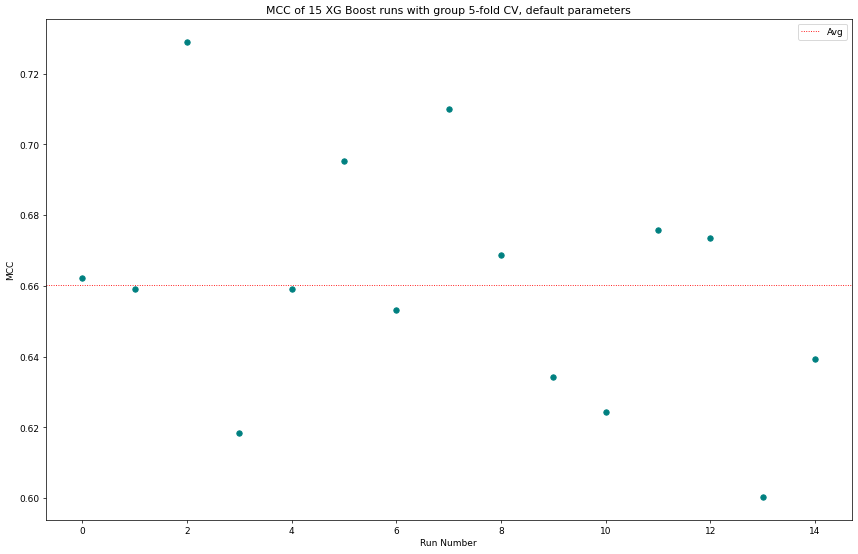

Average: 0.6601258198547484


In [23]:
Score_list = []
for i in range(0,15):
    file = "AC_dataset.csv"
    Training_Set, Testing_Set                     = Train_Test_Split(file)                                 #Create training and testing sets
    d_test, TestData, TestLabels                  = test_matrix(Testing_Set)
    # test(inData, classData, ValData, Vallabel)                                                          #Initial evaluation
    IT_list, LT_list, IV_list, LV_list = CV(Training_Set)                #Cross-validate training set  
    # train_features, train_labels, test_features, test_labels = data(Training_Set, Testing_Set)      

    all_prob_matrix = []
    for i in range(len(IT_list)):          
        inData = IT_list[i]
        classData = LT_list[i]
        ValData = IV_list[i]
        Vallabel = LV_list[i]

        minClass, minSize, maxSize  = find_minority_class(classData)                            #Determines imbalance
        BF                          = Balance_ratio(maxSize, minSize)                           #Determins number of balancing folds needed
        Input_folds, Output_folds   = Balance_Folds(BF, inData, classData, minClass, minSize)   # balance() and balance_data() functions are called under this
        d_train_list, d_val         = model_training_data(BF, Input_folds, Output_folds, ValData, Vallabel)
        # BF_GBC_HP                   = hyperparameter(BF, d_train_list, d_val)
        BF_GBC                      = BF_fitting(BF, d_train_list, d_val)
        # feature_importance(BF_GBC)
        Prob_matrix                 = BF_validate(BF_GBC, d_test)
        all_prob_matrix.append(Prob_matrix)

        Final_vote, Sum_PD, Sum_SNP = Weighted_Vote(Prob_matrix)
        
        evalutation(TestLabels, Final_vote)
        MCC = fold_MCC(Final_vote, TestLabels)
        
        MCC_final = final_evaluation(all_prob_matrix, TestLabels)
    Score_list.append(MCC_final)  
plot(Score_list)

In [24]:
np.savetxt("XGB_MCC_50_Final_MCCs.txt", Score_list, fmt = '%f')

In [25]:
# importance = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# f ='gain'
# BF_GBC[0]().get_score(importance_type= f)

# BF_GBC[0](get_score(fmap='', importance_type='weight'))